<h1>Tutorial: Gaussian Process Regression Explanation for Beginners</h1>

<h2> Gaussian Process Regression Overview (Preliminary 1/3) </h2>

Gaussian Process Regression (GPR) **differs** from traditional linear regression, which aims to fit a fixed set of parameters for a given dimensionality of the data. In linear regression, the goal is to find the best-fit line (or hyperplane) that minimizes the error between the observed data and the model's predictions. Specifically, for an $n$-dimensional problem, a linear regression model fits $n+1$ parameters (including an intercept).

In contrast, the **central idea** behind Gaussian Process Regression is that we are not fitting parameters but rather learning a distribution over all possible functions that can describe the data. This probabilistic framework allows GPR to provide not only predictions but also a measure of uncertainty for those predictions. A Gaussian Process (GP) is a subset of stochastic process (a collection of random variables), any finite number of which have a joint Gaussian distribution. It is completely specified by its mean function $ m(x) $ and covariance function $ k(x, x') $, also called a kernel. In GPR, we treat the function we are trying to predict as a sample from a Gaussian Process.

The **key strengths** of Gaussian Process Regression (GPR) lie in its flexibility and ability to model complex, non-linear relationships without assuming a specific functional form. As a non-parametric method, GPR adapts to data through a covariance function (kernel) that defines how data points are related. It provides not only predictions but also a measure of uncertainty, offering confidence intervals for each prediction. Additionally, by selecting different kernels, GPR can be customized to model a wide variety of patterns, making it highly versatile in handling real-world data.

The following tutorial is adapted from this lecture note (https://cs229.stanford.edu/section/cs229-gaussian_processes.pdf).

<h2> Statistical Model (Preliminary 2/3)</h2>

For a given dataset $ S = \left\{\left(x^{(i)}, y^{(i)}\right)\right\}_{i=1}^m $, where $x^{(i)}$ are input variables and $y^{(i)}$ are corresponding observations, we assume that the data is generated from some i.i.d. (independent and identically distributed) process. In Gaussian Process Regression, the relationship between the inputs $ x^{(i)} $ and outputs $ y^{(i)} $ is modeled as:

\begin{equation}
y^{(i)}=h\left(x^{(i)}\right)+\varepsilon^{(i)}, \quad \forall \{i=1, \ldots, m\}
\end{equation}

where:
- $ h(\cdot) $ is the latent function mapping from the input space $ \mathcal{X} $ to the real numbers $ \mathbb{R} $. This function is treated as a sample from a Gaussian Process (Explained Below).
- $ \varepsilon^{(i)} $ represents independent and identically distributed (i.i.d.) Gaussian noise with distribution $ \varepsilon^{(i)} \sim \mathcal{N}(0, \sigma^2) $, which accounts for observation noise in the data.

In GPR, rather than directly finding the function $ h(x) $, the goal is to infer the posterior distribution over functions given the observed data. This distribution allows us to make probabilistic predictions, including estimates of uncertainty, at new test points.
<br>
<br>
<br>
Note: The function $ h(x) $ in Gaussian Process Regression is **stochastic**, meaning it represents a distribution over functions rather than a single deterministic function. However, once a particular realization (sample) of the function is drawn from the Gaussian Process, the mapping from input $ x $ to output $ y $ becomes **deterministic**

<h2> Gaussain Process (Preliminary 3/3)</h2>

As mentioned, a **Gaussian Process (GP)** is a collection of random variables, where any finite subset of these variables follows a joint multivariate Gaussian distribution. This is a key feature of Gaussian Processes, making them a generalization of the multivariate Gaussian distribution to infinite dimensions. A GP is defined entirely by a mean function and a covariance function (also called the kernel), which capture the statistical relationships between the input points.

Let $x_1, x_2, \dots, x_m $ be a set of input points in some domain, it's associated set of random variables $h(x_1), h(x_2), \dots, h(x_m) $ has a distribution of:  

\begin{equation}
\left[\begin{array}{c}
h\left(x_1\right) \\
\vdots \\
h\left(x_m\right)
\end{array}\right] \sim \mathcal{N}\left(\left[\begin{array}{c}
m\left(x_1\right) \\
\vdots \\
m\left(x_m\right)
\end{array}\right],\left[\begin{array}{ccc}
k\left(x_1, x_1\right) & \cdots & k\left(x_1, x_m\right) \\
\vdots & \ddots & \vdots \\
k\left(x_m, x_1\right) & \cdots & k\left(x_m, x_m\right)
\end{array}\right]\right)
\end{equation}

Conventionally, we denote it as: 

\begin{equation}
    h(x) \sim \mathcal{GP}(m(x), k(x, x'))
\end{equation}

Where
- $ m(x) $ is the **mean function** of the Gaussian Process, typically assumed to be zero (i.e., $ m(x) = 0 $) unless prior knowledge suggests otherwise.
- $ k(x, x') $ is the **covariance function** (or kernel), which expresses the correlation between the function values $ h(x) $ and $ h(x') $. It defines how smooth or irregular we expect the function to be. The covariance matrix is symmetric, and each element $ k(x_i, x_j) $ represents the covariance between the function values at points $ x_i $ and $ x_j $.


\begin{equation}
\begin{aligned}
m(x) & = \mathbb{E}[h(x)] \\ 
k(x, x') & = \mathbb{E}\left[(h(x) - m(x))(h(x') - m(x'))\right] 
\end{aligned}

\begin{aligned}
& \quad \quad \quad \quad \forall x, x' \in \chi
\end{aligned}
\end{equation}

In [1]:
# To illustrate the logic of Gaussian Process Regression, this notebook is coded using only numpy and no other libraries.
import numpy as np
import matplotlib.pyplot as plt

<h2> Arbitrary True "Black-Box" Function </h2>

In Gaussian Process Regression, we often deal with an unknown or "black box" function that we aim to model. This function can be complex and is not explicitly defined, making it challenging to analyze directly. The purpose of using a black box function is to simulate real-world phenomena where the underlying relationship between inputs and outputs is not readily accessible.

\begin{equation}
f(x) = \sin(x) + \cos^2(x) + \text{noise}
\end{equation}

In [2]:
def black_box_function(X_train, noise, n_samples):
    return np.sin(X_train) + np.cos(X_train)**2 + noise * np.random.randn(n_samples, 1)

<h2> Kernel or Covariance Function</h2>

The kernel function defines how similar or related two input points are, which is crucial for modeling the underlying function. Without a kernel, GPR would lack a structured way to relate different inputs, making it impossible to infer the behavior of the function across the input space. A few common kernel examples include the Radial Basis Kernel, Matérn Kernel, Periodic Kernel. The Radial Basis Kernel or Squared Exponential Function is used for demonstration purpose.

\begin{equation}
k(\mathbf{x}, \mathbf{x}') = \exp\left(-\frac{1}{2l^2} \|\mathbf{x} - \mathbf{x}'\|^2\right)
\end{equation}

The RBF kernel intuitively captures the notion of correlation based on the distance between input points. When points are close together, they are considered highly correlated, and the kernel value approaches its maximum (typically normalized to 1). As points become further apart, their correlation diminishes, leading the kernel value to approach zero.

In [3]:
# Radial Basis Kernel
def rbf_kernel(X1, X2, length_scale=1.0):
    sqdist = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-0.5 * sqdist / length_scale**2)

To obtain some training data, we generate data using the black-box function defined above.

In [4]:
# Generating synthetic data
def generate_data( black_box_function, range = [-5,5], n_samples=10, noise=0.1):
    X_train = np.random.uniform(range[0], range[1], n_samples).reshape(-1, 1)
    y_train = black_box_function(X_train, noise, n_samples)
    return X_train, y_train

<h2> Bayesian Inference and Prediction of Mean Function</h2>

Besides the training dataset known to the model, $ S_{\text{train}} = \left\{\left(x_{\text{train}}^{(i)}, y_{\text{train}}^{(i)}\right)\right\}_{i=1}^{m_{\text{train}}} $, suppose we also have a testing dataset $ S_{\text{test}} = \left\{\left(x_{\text{test}}^{(j)}, y_{\text{test}}^{(j)}\right)\right\}_{j=1}^{m_{\text{test}}} $ drawn from the same i.i.d. distribution. The combined dataset $ S $ is defined as the union of the training set and the testing set: $ S = S_{\text{train}} \cup S_{\text{test}}.
$
<br>
<br>
<br>

**Basic Statistics (Review)**
<br>
Consider a random vector $ \mathbf{x} \in \mathbb{R}^n $ such that $ \mathbf{x} \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma}) $. This vector is partitioned into two sets: $ \mathbf{x}_A = [x_1, \ldots, x_r]^T \in \mathbb{R}^r $ and $ \mathbf{x}_B = [x_{r+1}, \ldots, x_n]^T \in \mathbb{R}^{n-r} $. Similarly, the mean vector $ \boldsymbol{\mu} $ and the covariance matrix $ \boldsymbol{\Sigma} $ are also partitioned as expressed below.

\begin{equation}
\mathbf{x} = \begin{pmatrix} \mathbf{x}_A \\ \mathbf{x}_B \end{pmatrix}, \quad \boldsymbol{\mu} = \begin{pmatrix} \boldsymbol{\mu}_A \\ \boldsymbol{\mu}_B \end{pmatrix}, \quad \boldsymbol{\Sigma} = \begin{pmatrix} \boldsymbol{\Sigma}_{AA} & \boldsymbol{\Sigma}_{AB} \\ \boldsymbol{\Sigma}_{BA} & \boldsymbol{\Sigma}_{BB} \end{pmatrix}.
\end{equation}

They have the property that $ A $ and $ B $ are both multivariate Gaussian distributed.
\begin{equation}
\begin{aligned}
& x_A \sim \mathcal{N}\left(\mu_A, \Sigma_{A A}\right) \\
& x_B \sim \mathcal{N}\left(\mu_B, \Sigma_{B B}\right)
\end{aligned}
\end{equation}

The conditional distribution of $ x_A $ given $ x_B $ has the expression below, which is also normally distributed. The proof of this is provided at the very end of this notebook. This equation is very important, as it describes the posterior distribution of the mean function and covariance function in Gaussian Process Regression, facilitating the prediction of unseen data.
\begin{equation}
\begin{gathered}
x_A \mid x_B \sim \mathcal{N}\left(\mu_A+\Sigma_{A B} \Sigma_{B B}^{-1}\left(x_B-\mu_B\right), \Sigma_{A A}-\Sigma_{A B} \Sigma_{B B}^{-1} \Sigma_{B A}\right) \\
x_B \mid x_A \sim \mathcal{N}\left(\mu_B+\Sigma_{B A} \Sigma_{A A}^{-1}\left(x_A-\mu_A\right), \Sigma_{B B}-\Sigma_{B A} \Sigma_{A A}^{-1} \Sigma_{A B}\right)
\end{gathered}
\end{equation}
<br>
<br>
**Posterior Distribution of Mean Function and Covariance Function (Gaussian Process Regression)**
<br>
The reason for the statistics review is that in Gaussian Process Regression, $ A $ represents the training dataset, $ B $ represents the testing dataset, and the conditional distribution is the result of Bayesian inference, where the prior belief is updated based on the observation of the training dataset. Given both the training and testing points $ X_{\text{train}} $ and $ X_{\text{test}} $, the function $ h(\cdot) $ has the following distribution, with a prior belief that the mean function is zero.

\begin{equation}
\left.\left[\begin{array}{c}
\overrightarrow{h_{train}} \\
\overrightarrow{h_{test}}
\end{array}\right] \right\rvert\, X_{train}, X_{test} \sim \mathcal{N}\left(\overrightarrow{0},\left[\begin{array}{cc}
K(X_{train}, X_{train}) & K\left(X_{train}, X_{test}\right) \\
K\left(X_{test}, X_{train}\right) & K\left(X_{test}, X_{test}\right)
\end{array}\right]\right)
\end{equation}

In GPR, we assume the noise random variables are i.i.d. and normally distributed.

\begin{equation}
\left[\begin{array}{c}
\overrightarrow{\varepsilon_{train}} \\
\overrightarrow{\varepsilon_{test}}
\end{array}\right] \sim \mathcal{N}\left(\overrightarrow{0},\left[\begin{array}{cc}
\sigma^2 I & \overrightarrow{0} \\
\overrightarrow{0}^T & \sigma^2 I
\end{array}\right]\right)
\end{equation}

From the structure of the regression model: 

\begin{equation}
y=h\left(x\right)+\varepsilon
\end{equation}

\begin{equation}
\begin{bmatrix}
    \vec{y}_{train} \\
    \vec{y}_{test}
\end{bmatrix}
\Bigg| X_{train}, X_{test} =
\begin{bmatrix}
    \vec{h}_{train} \\
    \vec{h}_{test}
\end{bmatrix}
\Bigg| X_{train}, X_{test}
+ 
\begin{bmatrix}
    \vec{\epsilon}_{train} \\
    \vec{\epsilon}_{test}
\end{bmatrix}
\Bigg| X_{train}, X_{test}
\sim \mathcal{N} \left( 
\vec{0},
\begin{bmatrix}
    K(X_{train}, X_{train}) + \sigma^2 I & K(X_{train}, X_{test}) \\
    K(X_{test}, X_{train}) & K(X_{test}, X_{test}) + \sigma^2 I
\end{bmatrix}
\right)
\end{equation}

Remember in the basic statistics review, the posterior distribution of normally distributed variable given another normally distributed variable has a known form of expression

\begin{equation}
\vec{y}_{test} \mid \vec{y}_{train}, X_{train}, X_{test} \sim \mathcal{N}(\mu^*, \Sigma^*)
\end{equation}

where

\begin{align*}
\mu^* &= K(X_{test}, X_{train})(K(X_{train}, X_{train}) + \sigma^2 I)^{-1} \vec{y} \\
\Sigma^* &= K(X_{test}, X_{test}) + \sigma^2 I - K(X_{test}, X_{train})(K(X_{train}, X_{train}) + \sigma^2 I)^{-1} K(X_{train}, X_{test})
\end{align*}



In [5]:
def gaussian_process_regression(X_train, y_train, X_test, noise_variance=1e-8, length_scale=1.0):
    # Covariance matrix for training points
    K = rbf_kernel(X_train, X_train, length_scale) + noise_variance * np.eye(len(X_train))
    # Covariance between training and test points
    K_s = rbf_kernel(X_train, X_test, length_scale)
    # Covariance for the test points
    K_ss = rbf_kernel(X_test, X_test, length_scale) + noise_variance * np.eye(len(X_test))
    
    
    # Compute the mean of the predictive distribution
    K_inv = np.linalg.inv(K)
    mu_s = K_s.T @ K_inv @ y_train
    # Compute the variance of the predictive distribution
    cov_s = K_ss - K_s.T @ K_inv @ K_s
    
    return mu_s, cov_s

In this example, we will generate 10 samples for the training data from the domain $ x \in [-5, 5] $. The reader is free to vary both the domain and the size of the training dataset. The testing dataset will consist of points densely sampled across the entire domain in order to visualize the uncertainty of the estimated function.

In [6]:
np.random.seed(12345)
n_samples = 10
X_train, y_train = generate_data(black_box_function=black_box_function, range = [-5,5], n_samples=n_samples,noise=0.01)

# Test points where we make predictions
X_test = np.linspace(-5, 5, 100).reshape(-1, 1)

# Run Gaussian Process Regression
mu_s, cov_s = gaussian_process_regression(X_train, y_train, X_test)

The function `plot_gp` visualizes the predictions of a Gaussian Process (GP) regression model by plotting the mean predictions and their associated uncertainty for a test dataset. The mean predictions, $ \mu_s $, are shown as a blue line, while the uncertainty is represented by a 95% confidence interval, $ \mu_s \pm 1.96 \times \sigma_s $, where $ \sigma_s $ is the standard deviation of the predictions derived from the covariance matrix. The confidence interval is shaded to indicate the range within which the true function is likely to lie, capturing the uncertainty in the GP's predictions.

In [12]:
# Step 4: Visualization of predictions
def plot_gp(X_train, y_train, X_test, mu_s, cov_s):
    # Mean prediction
    mu_s = mu_s.ravel()
    
    # Confidence intervals
    uncertainty = 1.96 * np.sqrt(np.diag(cov_s))
    
    plt.figure(figsize=(10, 6))
    
    # Plot training data
    plt.plot(X_train, y_train, 'kx', label='Training Data')
    
    # Plot GP mean
    plt.plot(X_test, mu_s, 'b', lw=2, label='Mean Prediction')

    # plt.plot(X_test,  np.sin(X_test), 'k', lw=2, label='True Function')
    plt.plot(X_test,  black_box_function(X_test,0,X_test.shape[-1]), 'k', lw=2, label='True Function')


    
    # Plot uncertainty bounds
    plt.fill_between(X_test.ravel(), mu_s - uncertainty, mu_s + uncertainty, 
                     color='blue', alpha=0.2, label='Confidence Interval')
    
    plt.ylim([-2,2])
    plt.title('Gaussian Process Regression')
    plt.legend()
    plt.show()

In this plot, you can see that the GP mean (blue line) closely follows the true function (black line) near the training data points but diverges in regions where it lacks information, with the confidence interval expanding accordingly.

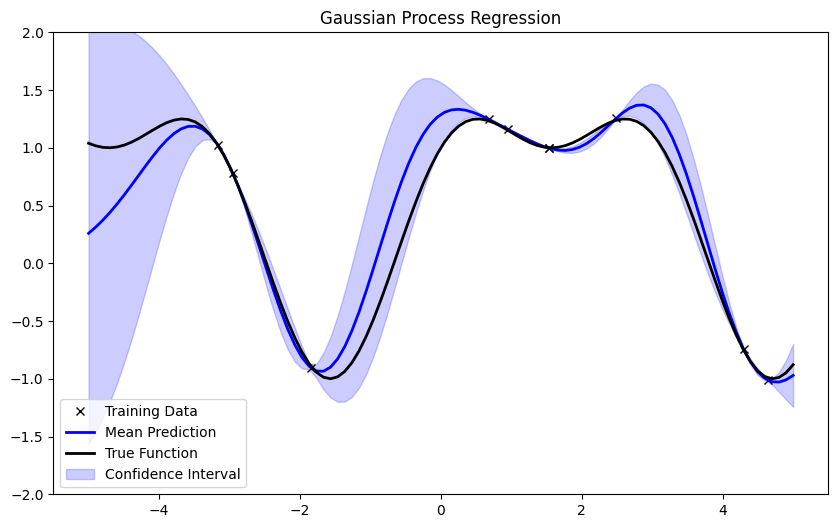

In [11]:
plot_gp(X_train, y_train, X_test, mu_s, cov_s)

<h1>Derivation of Posterior Distribution (Optional) </h1>

By **Bayes' theorem**, the conditional probability density function $ p(x_A \mid x_B) $ is given by the joint distribution of $ x_A $ and $ x_B $ divided by the marginal distribution of $ x_B $. The marginal distribution $ p(x_B) $ can be obtained by integrating out $ x_A $ from the joint distribution $ p(x_A, x_B; \mu, \Sigma) $.

**Step (1/7):** The joint distribution $ p(x_A, x_B) $ for the multivariate normal is given by:

   \begin{equation}
   p(x_A, x_B) = \frac{1}{(2\pi)^{m/2} |\Sigma|^{1/2}} \exp\left(-\frac{1}{2}(x - \mu)^T \Sigma^{-1} (x - \mu)\right)
   \end{equation}
   where $ \mu = \begin{bmatrix} \mu_A \\ \mu_B \end{bmatrix} $ is the mean vector and $ \Sigma = \begin{bmatrix} \Sigma_{AA} & \Sigma_{AB} \\ \Sigma_{BA} & \Sigma_{BB} \end{bmatrix} $ is the covariance matrix.

**Step (2/7):** The marginal distribution $ p(x_B) $ is obtained by integrating out $ x_A $ from the joint distribution:
  \begin{equation}
   p(x_B) = \int p(x_A, x_B) \, dx_A
   \end{equation}
   This results in the marginal distribution for $ x_B $, which follows a multivariate normal distribution with mean $ \mu_B $ and covariance $ \Sigma_{BB} $.

**Step (3/7):** Using Bayes' theorem, the conditional distribution of $ x_A $ given $ x_B $ is:
   \begin{equation}
   p(x_A \mid x_B) = \frac{p(x_A, x_B)}{p(x_B)} = \frac{1}{\int_{x_A} p(x_A, x_B; \mu, \Sigma) dx_A} \cdot \left[ \frac{1}{(2\pi)^{m/2}|\Sigma|} \exp \left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right) \right]
   \end{equation}

   \begin{equation}
   p(x_A \mid x_B) = \frac{1}{Z_1} \exp \left\{ -\frac{1}{2} \left( \begin{bmatrix} x_A \\ x_B \end{bmatrix} - \begin{bmatrix} \mu_A \\ \mu_B \end{bmatrix} \right)^T \begin{bmatrix} V_{AA} & V_{AB} \\ V_{BA} & V_{BB} \end{bmatrix} \left( \begin{bmatrix} x_A \\ x_B \end{bmatrix} - \begin{bmatrix} \mu_A \\ \mu_B \end{bmatrix} \right) \right\}
   \end{equation}
   
   where $ Z_1 $ is a normalization constant (independent of $x_A$) that ensures the distribution integrates to 1. The matrix $ V = \Sigma^{-1} $ is the precision matrix, partitioned into blocks corresponding to the components $ x_A $ and $ x_B $.

**Step (4/7):** By expanding the inner term with matrix multiplication inside the exponent due to the partition, we obtain this expression:

   \begin{equation}
   p(x_A \mid x_B) = \frac{1}{Z_1} \exp \left\{ (x_A - \mu_A)^T V_{AA} (x_A - \mu_A) + (x_A - \mu_A)^T V_{AB} (x_B - \mu_B) + (x_B - \mu_B)^T V_{BA} (x_A - \mu_A) + (x_B - \mu_B)^T V_{BB} (x_B - \mu_B) \right\}
   \end{equation}

**Step (5/7):**  Since x_B is already observed, x_B will be treated as a constant and only terms related to x_A will remain

\begin{equation}
p(x_A \mid x_B) = \frac{1}{Z_2} \exp \left( -\frac{1}{2} \left[ x_A^T V_{AA} x_A - 2x_A^T V_{AA} \mu_A + 2x_A^T V_{AB} (x_B - \mu_B) \right] \right)
\end{equation}

This represents the conditional probability distribution $ p(x_A \mid x_B) $, expressed as an exponential of a quadratic form. Here, $ Z_2 $ is a normalization constant, and $ V_{AA}, V_{AB} $ are submatrices of the inverse covariance matrix $ \Sigma^{-1} $, with $ \mu_A $ and $ \mu_B $ as mean vectors for $ x_A $ and $ x_B $, respectively.

**Step (6/7):** Using the method of completing the squares, one obtains a simplified expression

\begin{equation}
p(x_A \mid x_B) = \frac{1}{Z_3} \exp\left( -\frac{1}{2}(x_A - \mu')^T V_{AA}(x_A - \mu') \right)
\end{equation}
where $ Z_3 $ is a new proportionality constant that does not depend on $ x_A $, and where $ \mu' = \mu_A - V_{AA}^{-1} V_{AB}(x_B - \mu_B) $.

**Step (7/7):** The conditional distribution of x_A given x_B follows a Gaussian distribution as shown below:

\begin{equation}
x_A | x_B \sim \mathcal{N} \left( \mu_A - V_{AA}^{-1} V_{AB} (x_B - \mu_B), V_{AA}^{-1} \right)
\end{equation}

where

\begin{equation}
\begin{bmatrix}
V_{AA} & V_{AB} \\
V_{BA} & V_{BB}
\end{bmatrix}
=
\begin{bmatrix}
\left( \Sigma_{AA} - \Sigma_{AB} \Sigma_{BB}^{-1} \Sigma_{BA} \right)^{-1} & - \left( \Sigma_{AA} - \Sigma_{AB} \Sigma_{BB}^{-1} \Sigma_{BA} \right)^{-1} \Sigma_{AB} \Sigma_{BB}^{-1} \\
-\Sigma_{BB}^{-1} \Sigma_{BA} \left( \Sigma_{AA} - \Sigma_{AB} \Sigma_{BB}^{-1} \Sigma_{BA} \right)^{-1} & \left( \Sigma_{BB} - \Sigma_{BA} \Sigma_{AA}^{-1} \Sigma_{AB} \right)^{-1}
\end{bmatrix}
\end{equation}

The expression shown in the derivation of the Gaussian Process Regression section is now recovered

\begin{equation}
x_A \mid x_B \sim \mathcal{N}\left(\mu_A+\Sigma_{A B} \Sigma_{B B}^{-1}\left(x_B-\mu_B\right), \Sigma_{A A}-\Sigma_{A B} \Sigma_{B B}^{-1} \Sigma_{B A}\right)
\end{equation}